# Softmax 回归

逻辑回归可以应用与二分类问题，使用 softmax 回归可以解决多分类问题。  
如果有三种类别，四种特征就可以写为（使用逻辑回归的方法）：  
$$
o_1 = x_1w_{11} + x_2w_{12}+x_3w_{13}+x_4w_{14}+b_1
$$
$$
o_2 = x_1w_{21} + x_2w_{22}+x_3w_{23}+x_4w_{24}+b_2
$$
$$
o_2 = x_1w_{31} + x_2w_{32}+x_3w_{33}+x_4w_{34}+b_3
$$

写成矩阵形式就是：
$$
O(x_1,x_2,x_3) = 
\begin{bmatrix} x_1
  & x_2  & x_3
\end{bmatrix} \cdot 
\begin{bmatrix} w_{11}
  & w_{12} & w_{13} \\ w_{21}
  & w_{22}  & w_{23} \\ w_{31}
  & w_{32}  & w_{33}
\end{bmatrix}^T
+ \begin{bmatrix} b_1
 \\b_2
 \\b_3

\end{bmatrix}
$$
也就是：
$$
o = x * w^T + b
$$

softmax回归的形式  
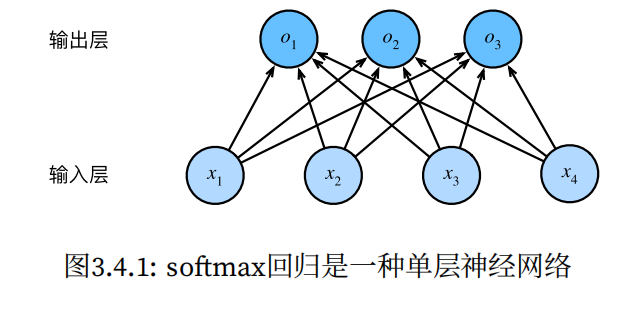

因为将线性层的输出直接视为概率时存在一些问题：一方面，我们没有限制这些输出数字的总和为1。另一方面，根据输入的不同，它
们可以为负值。所以后面使用softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质。

softmax函数可以表示为：  
$$
\hat{y} = softmax(o)
$$
$$
\hat{y_j} = \frac{exp(o_j)}{\sum_kexp(o_k)}
$$

同样可以使用极大似然估计来得到其损失函数。  
$$
P(Y|X) = \prod^n_{i=1}P(y^i|x^i)
$$
最大化P(Y|x)相当于最小化负对数似然。  
$$
-logP(Y|X) = \sum^n_{i=1}-logP(y^i|x^i) = \sum^n_{i=1}l(y^i, \hat{y}^i)
$$
$$
l(y,\hat(y)) = -\sum^q_{j=1}y_ilog\hat{y_j}
$$

导入库

In [242]:
import torch
import torch.autograd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import dataset.fashion_mnist.utils.mnist_reader as mnist_reader

使用了 fashion-mnist 数据集，读取数据集并划分训练集和测试集

In [243]:
x_train, y_train = mnist_reader.load_mnist('dataset/fashion_mnist/data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('dataset/fashion_mnist/data/fashion', kind='t10k')

In [244]:
x_train = x_train.astype("float")
x_test = x_test.astype("float")
y_train = y_train.astype("float")
y_test = y_test.astype("float")

图片的标签

In [245]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

可视化

In [246]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img.reshape(28, 28))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

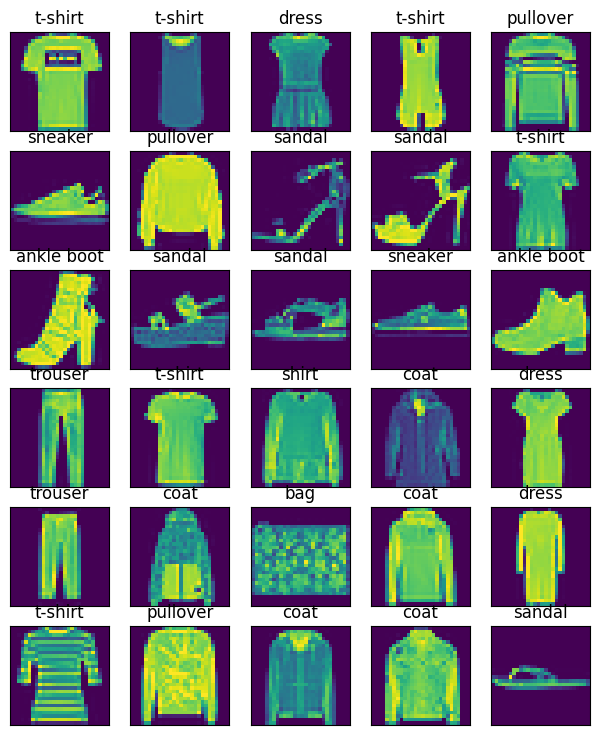

In [247]:
show_images(x_train[1:31], 6, 5, titles=get_fashion_mnist_labels(y_train[1:31]));

In [248]:
num_outputs = 10
num_inputs = 28 * 28

In [249]:
w = np.random.uniform(0, 0.1, size = (num_outputs, num_inputs))
b = np.zeros(num_outputs)

In [250]:
x_train = torch.tensor(x_train, requires_grad=True)
y_train = torch.tensor(y_train, requires_grad=True)
x_test = torch.tensor(x_test, requires_grad=True)
y_test = torch.tensor(y_test, requires_grad=True)
w = torch.tensor(w, requires_grad=True)
b = torch.tensor(b, requires_grad=True)

softmax函数

In [251]:
def f(x, w, b):
    return torch.mm(w, x.view(-1, 1)) + b.view(-1, 1)

In [252]:
def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(dim=0, keepdim=True)
    return x_exp / partition

In [253]:
def net(X, w, b):
    return softmax(f(X, w, b))

In [254]:
def J(y, y_hat):
    return - y * torch.log(y_hat)

In [241]:
yhat = net(x_train[1], w, b)
print(yhat)

tensor([[2.3401e-04, 9.4189e-04, 1.7946e-04,  ..., 7.1417e-05, 8.5742e-04,
         1.1794e-04],
        [5.4470e-04, 8.0748e-04, 5.8243e-04,  ..., 3.0457e-05, 3.0235e-04,
         3.7101e-04],
        [5.2585e-06, 7.5983e-04, 7.6059e-04,  ..., 9.6474e-04, 3.9732e-04,
         3.3677e-04],
        ...,
        [8.9333e-04, 1.4539e-04, 6.3057e-04,  ..., 1.6677e-04, 1.3863e-04,
         5.1560e-04],
        [7.3665e-04, 6.5093e-04, 5.4115e-04,  ..., 6.3842e-04, 7.6931e-04,
         2.6429e-04],
        [2.1053e-04, 3.3200e-04, 7.3489e-04,  ..., 6.9357e-05, 9.3530e-04,
         4.2196e-04]], dtype=torch.float64, requires_grad=True)


训练

In [267]:
lr = 0.001
n = x_train.size()[0]

for i in range(0, 5):
    yhat = []
    L = torch.tensor([0.], requires_grad=True)
    for j in range(0, n):
        y_cur = net(x_train[i], w, b)
        yhat = y_cur.argmax()
        loss = J(y_train[i], yhat)
        L = L + loss
    L.backward(L)
    print(w.grad)

None


KeyboardInterrupt: 

测试

In [ ]:
yhat = net(x_train[0], w, b)
print(yhat)

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], dtype=torch.float64, grad_fn=<DivBackward0>)
